###  Energy Generation Time Series
##### U.S. Electricity Generation (https://www.kaggle.com/datasets/ravishah1/electricity-generation-time-series)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn import preprocessing
import warnings
warnings.simplefilter("ignore", UserWarning)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from scipy import signal
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pmdarima import auto_arima 
from sklearn.metrics import mean_squared_error,  mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
us_el_selected=pd.read_csv('us_el_selected.csv',index_col=[0])
us_el_selected['Date']=pd.to_datetime(us_el_selected['Date'])
us_el_selected = us_el_selected.loc[:,:'United States : all sectors']
us_el_selected.set_index('Date', inplace=True)

In [3]:
us_el_selected.head()

,United States : all sectors
Date,
2001-01-01,332493
2001-02-01,282940
2001-03-01,300707
2001-04-01,278079
2001-05-01,300492


In [4]:
train = us_el_selected.loc['2001-01-01':'2020-12-01']
test = us_el_selected.loc['2021-01-01':'2022-03-01']

#### Time Series Decomposition 

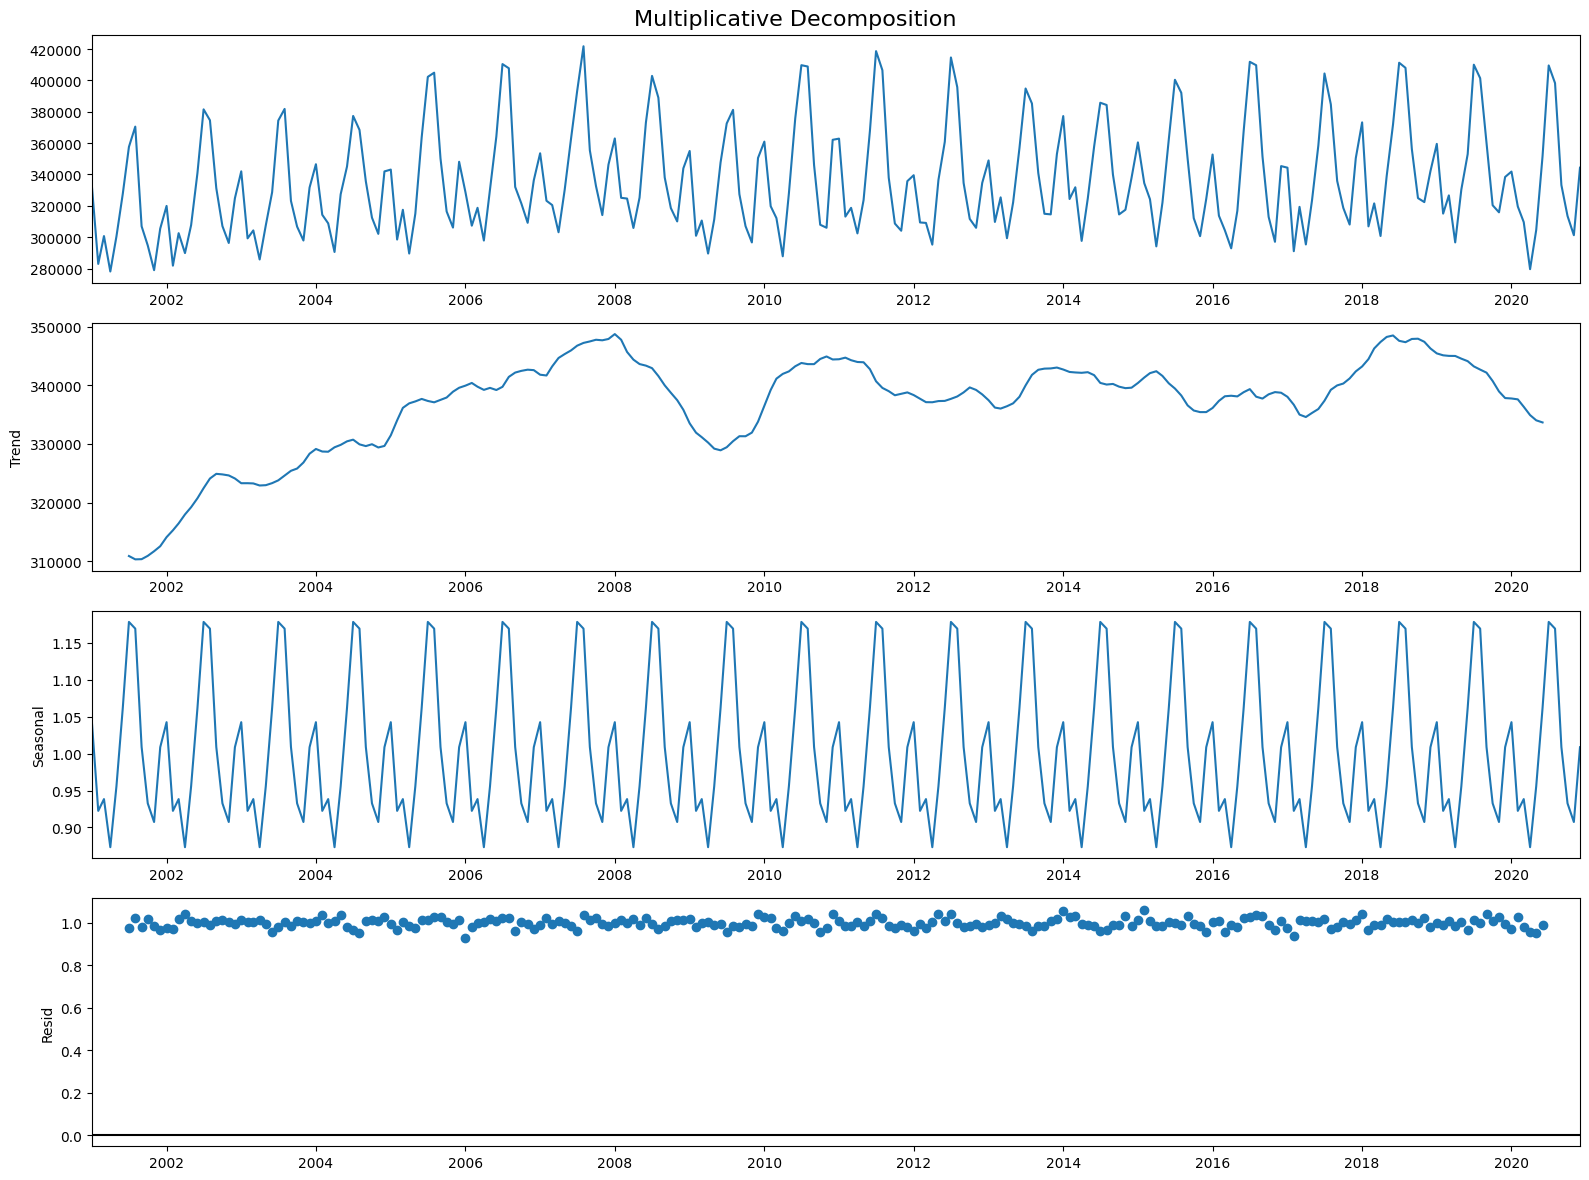

In [5]:
multiplicative = seasonal_decompose(train, model='multiplicative')
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout();

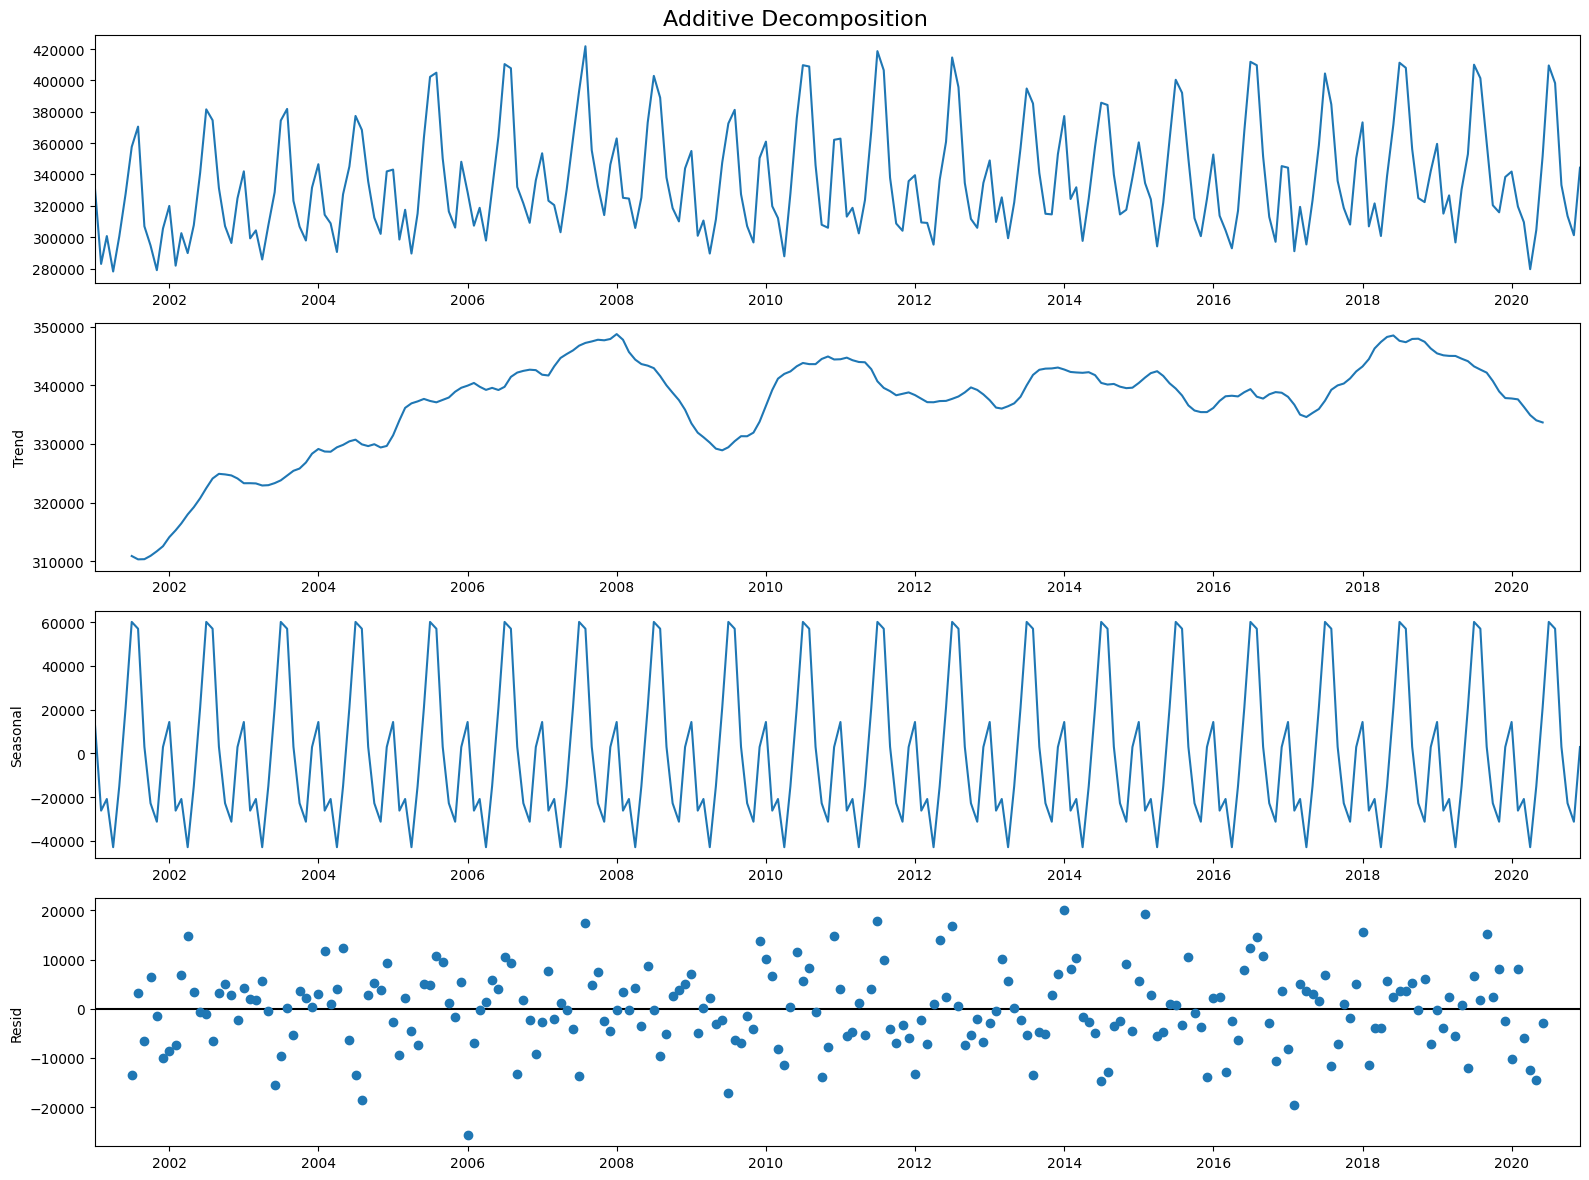

In [6]:
additive = seasonal_decompose(train, model='additive')
plt.rcParams.update({'figure.figsize': (16,12)})
additive.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout();

#### Autocorrleation

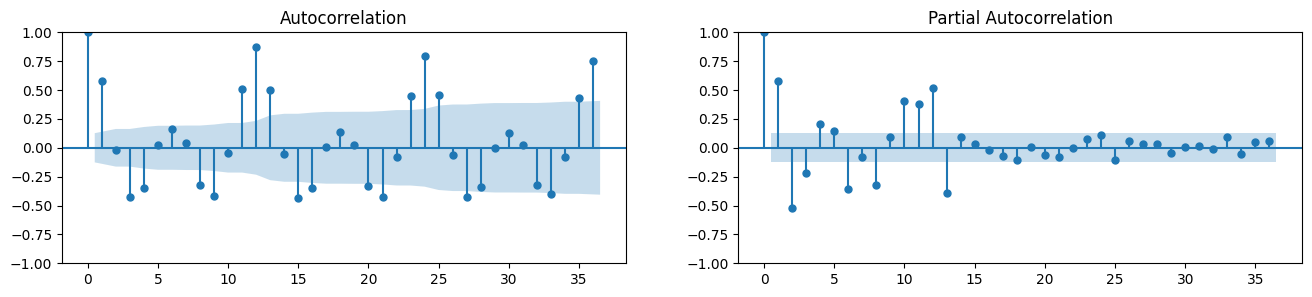

In [7]:
fig, axes = plt.subplots(1,2,figsize=(16,3))
plot_acf(train, lags=36,ax=axes[0])
plot_pacf(train, lags=36, ax=axes[1], method='ywm')
plt.show();

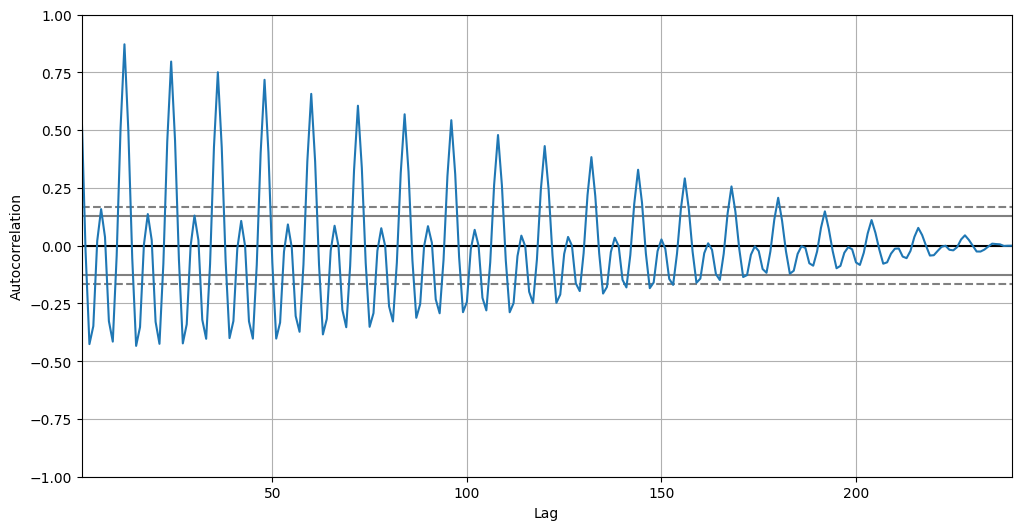

In [8]:
plt.rcParams.update({'figure.figsize':(12,6)})
autocorrelation_plot(train);

#### Stationarity Test

ADF: 

Null Hypothesis (H0): Series is non-stationary.

Alternate Hypothesis(H1): Series is stationary.


In [13]:
def adfuller_result(data):
    print ('Results of Dickey-Fuller Test:')
    adfuller_test = adfuller(data, autolag='AIC')
    adfuller_results = pd.Series(adfuller_test[0:4], index=['ADF Statistic','p-value','Lag_Used','Number of Observstions Used'])
    for key, value in adfuller_test[4].items():
        adfuller_results['Critical Value (%s)'%key] = value
    print (adfuller_results)

    if adfuller_test[1]>0.05:
        print("Null hypothesis (= Series is not stationary) can not be rejected.(p-value: %.5f)" %adfuller_test[1])
    else:
        print("Null hypothesis (= Series is not stationary) can be rejected.(p-value: %.5f)" %adfuller_test[1])


In [14]:
adfuller_result(train)

Results of Dickey-Fuller Test:
ADF Statistic                   -3.632594
p-value                          0.005168
Lag_Used                        14.000000
Number of Observstions Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64
Null hypothesis (= Series is not stationary) can be rejected.(p-value: 0.00517)


KPSS: 

Null Hypothesis (H0): Series is trend stationary.

Alternate Hypothesis(H1): Series is non-stationary.

In [15]:
def kpss_result(data):
    print ('Results of KPSS Test:')
    kpsstest = kpss(data, regression='c', nlags="auto")
    kpss_results = pd.Series(kpsstest[0:3], index=['Kpss Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_results['Critical Value (%s)'%key] = value
    print (kpss_results)
    
    if kpsstest[1]>0.05:
        print("Null hypothesis (= Series is trend stationary) can not be rejected.(p-value: %.5f)" %kpsstest[1])
    else:
        print("Null hypothesis (= Series is trend stationary) can be rejected.(p-value: %.5f)" %kpsstest[1])

In [16]:
kpss_result(train)

Results of KPSS Test:
Kpss Statistic           0.580494
p-value                  0.024410
#Lags Used               7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Null hypothesis (= Series is trend stationary) can be rejected.(p-value: 0.02441)


#### Interpretation of ADF test and KPSS test reuslts

ADF test concludes that the series is stationary while KPSS test concludes non-stationary.

Therefore, the stationary needs to be checked after differencing based on below.


[ How to interpret the results of ADF test and KPSS test ]

Case 1: Both tests conclude stationary – "stationary"

Case 2: Both tests conclude non-stationary – "non-stationary"

Case 3: ADF concludes non-stationary while KPSS concludes stationary – "trend stationary" (The trend needs to be removed and the deterended series is checked for stationarity.)

Case 4: ADF concludes stationary while KPSS concludes non-stationary – "difference stationary" (Differencing is to be used and the differenced series is checked for stationarity.)

https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

In [17]:
adfuller_result(train.diff(1).dropna())

Results of Dickey-Fuller Test:
ADF Statistic                   -5.293077
p-value                          0.000006
Lag_Used                        13.000000
Number of Observstions Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64
Null hypothesis (= Series is not stationary) can be rejected.(p-value: 0.00001)


In [18]:
kpss_result(train.diff(1).dropna())

Results of KPSS Test:
Kpss Statistic            0.114016
p-value                   0.100000
#Lags Used               54.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Null hypothesis (= Series is trend stationary) can not be rejected.(p-value: 0.10000)


c:\Users\y_tat\miniconda3\envs\pro_env\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Source/Reference:

https://www.kaggle.com/datasets/ravishah1/electricity-generation-time-series

https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/

https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python

https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf

https://www.wisdomgeek.com/development/machine-learning/sarima-forecast-seasonal-data-using-python/
